# Task 2.1 Vanilla GAN

In [2]:
import torch
import torch.nn.functional as f
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Load Mnist data

In [3]:
batch_size = 64

# Download the dataset and create the dataloaders
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

mnist_test = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

image_size =28
Z_dim = 100
X_dim = image_size*image_size
# y_dim = train_labels.shape[1]
h_dim = 128
c = 0
lr = 1e-3

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 37353328.36it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 1104134.44it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 10295212.56it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 8099714.61it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# Initiate weight Xavier

In [4]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

# Generator

In [43]:
Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)


def G(z):
    h = f.relu(z @ Wzh + bzh.repeat(z.size(0), 1))
    X = f.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X

# Discriminator

In [44]:
Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Why = xavier_init(size=[h_dim, 1])
bhy = Variable(torch.zeros(1), requires_grad=True)


def D(X):
    h = f.relu(X @ Wxh + bxh.repeat(X.size(0), 1))
    y = f.sigmoid(h @ Why + bhy.repeat(h.size(0), 1))
    return y


G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
params = G_params + D_params

In [ ]:
for i in params:
  print(i.shape)

torch.Size([128])

# Train

In [56]:
def reset_grad():
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())


G_solver = optim.Adam(G_params, lr=1e-3)
D_solver = optim.Adam(D_params, lr=1e-3)


In [57]:
loss_function = nn.BCELoss()

In [20]:
#num_epochs = 100000
num_epochs = 50

D_avg_losses = []
G_avg_losses = []

def train_GAN(train_loader, loss_function, G, D, num_epochs):
  for epoch in range(num_epochs):
    D_losses = 0
    G_losses = 0

    # minibatch training
    for i, (images, _) in enumerate(train_loader):
      mini_batch = images.size()[0]

      ones_label = Variable(torch.ones(mini_batch, 1))
      zeros_label = Variable(torch.zeros(mini_batch, 1))
      # Sample data
      z = Variable(torch.randn(mini_batch, Z_dim))
      X = images.view(-1, X_dim)
      X = Variable(X)

      # Dicriminator forward-loss-backward-update
      G_sample = G(z)
      D_real = D(X)
      D_fake = D(G_sample)

      D_loss_real = loss_function(D_real, ones_label)
      D_loss_fake = loss_function(D_fake, zeros_label)
      D_loss = D_loss_real + D_loss_fake

      D_loss.backward()
      D_solver.step()

      # Housekeeping - reset gradient
      reset_grad()

      # Generator forward-loss-backward-update
      z = Variable(torch.randn(mini_batch, Z_dim))
      G_sample = G(z)
      D_fake = D(G_sample)

      G_loss = loss_function(D_fake, ones_label)

      G_loss.backward()
      G_solver.step()

      # Housekeeping - reset gradient
      reset_grad()

      # loss values
      D_losses += D_loss.data.numpy()
      G_losses += G_loss.data.numpy()

    D_avg_loss = D_losses/mini_batch
    G_avg_loss = G_losses/mini_batch

    # avg loss values for plot
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)

    # Print and plot every now and then
    if epoch % 1 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(epoch, D_loss.data.numpy(), G_loss.data.numpy()))

train_GAN(train_loader, loss_function, G, D, 5)

Iter-0; D_loss: 0.0022551966831088066; G_loss: 9.535200119018555
Iter-1; D_loss: 0.01068241335451603; G_loss: 7.609567165374756
Iter-2; D_loss: 0.02064671739935875; G_loss: 6.866867542266846
Iter-3; D_loss: 0.04155722260475159; G_loss: 6.957976341247559
Iter-4; D_loss: 0.22988960146903992; G_loss: 4.75051736831665
Iter-5; D_loss: 0.44779303669929504; G_loss: 4.851503372192383
Iter-6; D_loss: 0.46968787908554077; G_loss: 3.985485792160034
Iter-7; D_loss: 0.42002564668655396; G_loss: 3.8311736583709717
Iter-8; D_loss: 0.46852296590805054; G_loss: 3.6562633514404297
Iter-9; D_loss: 0.36956560611724854; G_loss: 3.7300240993499756
Iter-10; D_loss: 0.767409086227417; G_loss: 2.505608081817627
Iter-11; D_loss: 0.5135930776596069; G_loss: 2.911527156829834
Iter-12; D_loss: 0.5063055157661438; G_loss: 1.7468600273132324
Iter-13; D_loss: 0.8066165447235107; G_loss: 1.891127347946167
Iter-14; D_loss: 1.0716533660888672; G_loss: 2.3769547939300537
Iter-15; D_loss: 1.178372859954834; G_loss: 1.8669

# Plot result

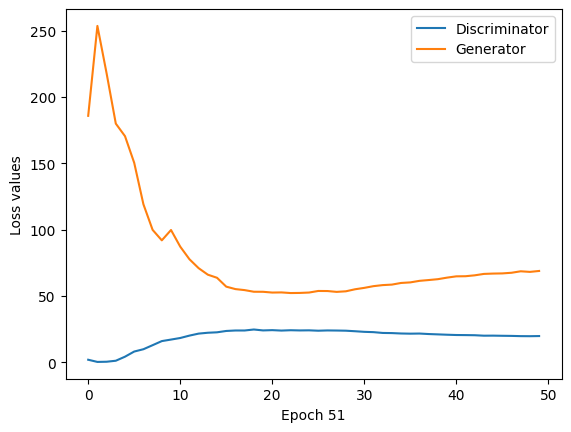

In [21]:
def plot_loss(d_losses, g_losses, num_epoch):
    fig, ax = plt.subplots()
    plt.xlabel('Epoch {0}'.format(num_epoch + 1))
    plt.ylabel('Loss values')
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.legend()

plot_loss(D_avg_losses, G_avg_losses, num_epochs)

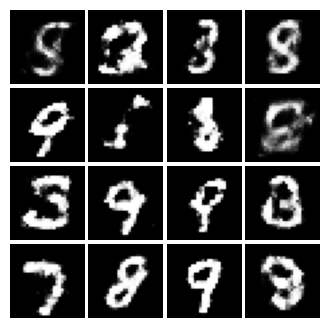

In [22]:
z = Variable(torch.randn(32, Z_dim))
samples = G(z).data.numpy()[:16]

fig = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.05, hspace=0.05)

for i, sample in enumerate(samples):
  ax = plt.subplot(gs[i])
  plt.axis('off')
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_aspect('equal')
  plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

# Task 2.3 CGAN

In [19]:
y_dim = 10

In [20]:
Wzh = xavier_init(size=[Z_dim + y_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)

def G_c(z, c):

    inputs = torch.cat([z, c], 1)

    h = f.relu(inputs @ Wzh + bzh.repeat(inputs.size(0), 1))
    X = f.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X

In [21]:
Wxh = xavier_init(size=[X_dim + y_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Why = xavier_init(size=[h_dim, 1])
bhy = Variable(torch.zeros(1), requires_grad=True)

def D_c(X, c):
    inputs = torch.cat([X, c], 1)
    h = f.relu(inputs @ Wxh + bxh.repeat(inputs.size(0), 1))
    y = f.sigmoid(h @ Why + bhy.repeat(h.size(0), 1))
    return y

In [25]:
to_onehot = nn.Embedding(10, 10)

def train_CGAN(train_loader, loss_function, G_c, D_c, num_epochs):

  for epoch in range(num_epochs):
    D_losses = 0
    G_losses = 0

    # minibatch training
    for i, (images, c) in enumerate(train_loader):
      mini_batch = images.size()[0]

      ones_label = Variable(torch.ones(mini_batch, 1))
      zeros_label = Variable(torch.zeros(mini_batch, 1))
      # Sample data
      z = Variable(torch.randn(mini_batch, Z_dim))
      X = images.view(-1, X_dim)
      X = Variable(X)

      # Dicriminator forward-loss-backward-update
      c = to_onehot(c)
      # c = Variable(torch.from_numpy(c))
      # D_solver.zero_grad()
      G_sample = G_c(z, c)
      D_real = D_c(X, c)
      D_fake = D_c(G_sample, c)

      D_loss_real = loss_function(D_real, ones_label)
      D_loss_fake = loss_function(D_fake, zeros_label)
      D_loss = D_loss_real + D_loss_fake

      D_loss.backward(retain_graph=True)
      D_solver.step()

      # Housekeeping - reset gradient
      reset_grad()


      # Generator forward-loss-backward-update
      # G_solver.zero_grad()

      z = Variable(torch.randn(mini_batch, Z_dim))
      G_sample = G_c(z, c)
      D_fake = D_c(G_sample, c)

      G_loss = loss_function(D_fake, ones_label)
      G_loss.backward()
      G_solver.step()

      # Housekeeping - reset gradient
      reset_grad()

      # loss values
      D_losses += D_loss.data.numpy()
      G_losses += G_loss.data.numpy()

    D_avg_loss = D_losses/mini_batch
    G_avg_loss = G_losses/mini_batch

    # avg loss values for plot
    D_avg_losses.append(D_avg_loss)
    G_avg_losses.append(G_avg_loss)

    # Print and plot every now and then
    if epoch % 1 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(epoch, D_loss.data.numpy(), G_loss.data.numpy()))


In [26]:
def reset_grad():
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())

G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
params = G_params + D_params

G_solver = optim.Adam(G_params, lr=1e-3)
D_solver = optim.Adam(D_params, lr=1e-3)

In [27]:
num_epochs = 20

D_avg_losses = []
G_avg_losses = []
# loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCELoss()
train_CGAN(train_loader, loss_function, G_c, D_c, num_epochs)

Iter-0; D_loss: 0.005906104110181332; G_loss: 6.203672409057617
Iter-1; D_loss: 0.014586110599339008; G_loss: 5.643299579620361
Iter-2; D_loss: 0.02929837629199028; G_loss: 7.364986419677734
Iter-3; D_loss: 0.15921349823474884; G_loss: 4.757595539093018
Iter-4; D_loss: 0.18167123198509216; G_loss: 5.136035919189453
Iter-5; D_loss: 0.20687466859817505; G_loss: 5.4222092628479
Iter-6; D_loss: 0.28478461503982544; G_loss: 4.968319416046143
Iter-7; D_loss: 0.6529019474983215; G_loss: 4.470394134521484
Iter-8; D_loss: 0.6443325877189636; G_loss: 3.214101552963257
Iter-9; D_loss: 0.6198406219482422; G_loss: 2.7014803886413574
Iter-10; D_loss: 0.5824156999588013; G_loss: 2.2760519981384277
Iter-11; D_loss: 0.39802807569503784; G_loss: 2.3708972930908203
Iter-12; D_loss: 0.991801381111145; G_loss: 2.8715994358062744
Iter-13; D_loss: 0.7426195740699768; G_loss: 2.7262063026428223
Iter-14; D_loss: 0.8118224143981934; G_loss: 2.367093086242676
Iter-15; D_loss: 0.38038086891174316; G_loss: 2.27296

In [58]:
# generate digit use generator
digit = 4
z = Variable(torch.randn(32, Z_dim))
c = np.ones(shape=[32,], dtype='long')
c = digit*c
c = to_onehot(torch.tensor(c))

In [54]:
samples = G_c(z,c).data.numpy()[:16]

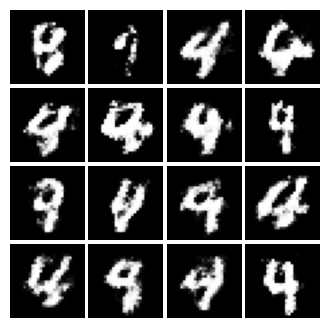

In [55]:
# plot generated digit

fig = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(4, 4)
gs.update(wspace=0.05, hspace=0.05)

for i, sample in enumerate(samples):
  ax = plt.subplot(gs[i])
  plt.axis('off')
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_aspect('equal')
  plt.imshow(sample.reshape(28, 28), cmap='Greys_r')